https://pythonprogramming.net/q-learning-analysis-reinforcement-learning-python-tutorial/

# Vanilla Q-Learning

In [1]:
import numpy as np
from enum import IntEnum
from gym import Env
from gym.spaces import Box, Discrete, MultiDiscrete
import seaborn as sns
from matplotlib import pyplot as plt
from dataclasses import dataclass

In [2]:
@dataclass
class QSettings():
    nepisodes: int
    epsilon: float
    discount: float
    learning_rate: float
        
    def __post_init__(self):
        self.epsilon_start_decaying = 1
        self.epsilon_end_decaying = self.nepisodes
        self.epsilon_decay_value = self.epsilon/(self.epsilon_end_decaying - self.epsilon_start_decaying)

''' Helper class to enumerate actions in the grid levels '''
class Actions(IntEnum):  
    STAY  = 0    
    UP = 1
    LEFT  = 2
    DOWN = 3
    RIGHT  = 4

    # get the enum name without the class
    def __str__(self): return self.name   

In [3]:
class Environment(Env):
    def __init__(self, size: int, starting_location: tuple, end_location: tuple, nobstacles: int, qsettings: QSettings):
        self.__verify_input(size, starting_location, end_location, nobstacles)
        self.size = size
        self.nrows = size
        self.ncols = size
        self.mapsize = (size, size)
        self.starting_location = starting_location
        self.default_location = self.starting_location
        self.startingrow, self.startingcol = self.starting_location
        self.end_location = end_location
        self.endrow, self.endcol = self.end_location
        self.nobstacles = nobstacles
        self.qsettings = qsettings
        self.actions = ['up', 'down', 'left', 'right']
        self.action_space = Discrete(len(self.actions))
        self.observation_space = MultiDiscrete([ self.nrows, self.ncols ])
        
        self.x, self.y = self.starting_location
        
        self.obstacles = []
        self.checkpoinst = []
        self.rewards = np.full((self.nrows, self.ncols), -1)
        #self.qtable = np.random.uniform(low=-1, high=1, size=[self.size, self.size, self.action_space.n])
        self.basereward = -1
        self.enemyreward = -300
        self.endreward = 300
        
        self.qtable = np.full(shape= [self.size, self.size, self.action_space.n], fill_value=0)
        
        self.__build_obstacles__()
        self.__build_rewards__()
        
        self.initialized = True
        #self.__DISCRETE_OS_SIZE = [self.size] * len(self.observation_space.high)
        #self.__DISCRETE_OS_WIN_SIZE = (self.observation_space.high - self.observation_space.low)/self.__DISCRETE_OS_SIZE
        
    def __verify_input(self, size: int, starting_location: tuple, end_location: tuple, nenemies: int):
        if (size <= 0):
            raise ValueError("Cannot set negative or null size")
        if (len(starting_location) != 2):
            raise ValueError(f"Starting location must have 2 elements, received {len(starting_location)}. Starting x and starting y.")
        if (starting_location[0] >= size or starting_location[1] >= size):
            raise ValueError(f"Starting location is outside of map bounds. Received location of {starting_location}, but map is a square with {size} tiles.")
        if (len(end_location) != 2):
            raise ValueError(f"End location must have 2 elements, received {len(end_location)}. Starting x and starting y.")
        if (end_location[0] >= size or end_location[1] >= size):
            raise ValueError(f"End location is outside of map bounds. Received location of {end_location}, but map is a square with {size} tiles.")
        if (end_location == starting_location):
            raise ValueError("Cannot set ending location on starting location.")
        if (nenemies > size*size - 2):
            raise ValueError(f"Too many enemies set. Max value allowed is {size*size - 2}, but received {nenemies}")
        if (nenemies <= 0):
            raise ValueError("Cannot set negative or no enemies")
            
        
    def __build_obstacles__(self):
        if len(self.obstacles) <= 0:
            while len(self.obstacles) < self.nobstacles:
                randrow = np.random.randint(self.nrows)
                randcol = np.random.randint(self.ncols)
                if (randrow, randcol) not in self.obstacles:
                    if (randrow,randcol) != self.starting_location and (randrow,randcol) != self.end_location:
                        self.obstacles.append((randrow, randcol))
    def __build_checkpoints(self):
        if len(self.checkpoints <= 0):
            while len(self.checkpoints) < 5:
                randrow = np.random.randint(self.nrows)
                randcol = np.random.randint(self.ncols)
                if (randrow, randcol) not in self.checkpoints:
                        if (randrow,randcol) != self.starting_location and (randrow,randcol) != self.end_location and (randrow, randcol) not in self.obstacles:
                            self.checkpoints.append((randrow, randcol))
                        
    def __build_rewards__(self):
        for obstacle in self.obstacles:
            ob_row, ob_col = obstacle
            self.rewards[ob_row][ob_col] = self.enemyreward
        self.rewards[self.end_location[0]][self.end_location[1]] = self.endreward
    
    
    def is_enemy(self, row, col):
        return self.rewards[row][col] == self.enemyreward
    def is_end(self, row, col):
        return self.rewards[row][col] == self.endreward
    
    
    def get_next_action(self, current_row_index, current_column_index):
        """Next action is decided based on the epsilon-greedy algorithm.
        If a random number is smaller than a value epsilon, the max value from the queue table is selected.
        Otherwise, if the random number is larger, pick a random action
        """
        value = 0
        if np.random.random() >= self.qsettings.epsilon:
            value = np.argmax(self.qtable[current_row_index, current_column_index])
        else: #choose a random action
            value = np.random.randint(len(self.actions))
        return value
        
    def get_next_location(self,current_row_index, current_column_index, action_index: int):
        new_row_index = current_row_index
        new_column_index = current_column_index
        try:
            if self.actions[action_index] == 'up' and current_row_index > 0:
                new_row_index -= 1
            elif self.actions[action_index] == 'right' and current_column_index < self.ncols - 1:
                new_column_index += 1
            elif self.actions[action_index] == 'down' and current_row_index < self.nrows - 1:
                new_row_index += 1
            elif self.actions[action_index] == 'left' and current_column_index > 0:
                new_column_index -= 1
        except:
            print("!!" + str(action_index))
        return new_row_index, new_column_index
    
    def build_state(self, *args):
        if len(args)==1:
            # state
            state = args[0]
            return np.array([state,]) 
        elif len(args)==2:
            # x, y
            x = args[0]
            y = args[1]
            return np.array([[x, y],])  
        else:
            raise ValueError("[BuildState] Invalid number of arguments passed")
    
    def step(self, actionindex: int):
        self.x, self.y = self.get_next_location(self.x, self.y, actionindex)
        newstate = (self.x, self.y)
        truncated = False
        # Calculate reward
        reward = self.rewards[self.x][self.y]
        done = self.is_end(self.x, self.y) or self.is_enemy(self.x, self.y)
        info = {}
        return newstate, reward, done, truncated, info
    
    def showmap(self):
        print(len(self.obstacles))
        if len(self.obstacles) > 0:
            fig, ax = plt.subplots(figsize=(9,9))
            ax.set_title("Reward map")
            ax.set_xlabel("col")
            ax.set_ylabel("row")
            rewardmap = self.rewards
            rewardmap[self.startingrow][self.startingcol] = -50
            ax.imshow(rewardmap)
            plt.show()
    
    def showpath(self, path: list):
        if len(path) > 0:
            plt.clf()
            newmap = self.rewards
            newmap[path[0][0]][path[0][1]] = -50
            print("===> ",path)
            for pos in path:
                r, c = pos
                newmap[r][c] = 100
            fig2, ax2 = plt.subplots(figsize=(9,9))
            ax2.set_title("Reward map")
            ax2.set_xlabel("col")
            ax2.set_ylabel("row")
            ax2.imshow(newmap)
        plt.show()
        
    def reset(self, randomize: bool = False):
        if randomize:
            state = np.random.randint(low=0, high=self.size, size=(2,))
        else:
            state = self.default_location
        self.x = state[0]
        self.y = state[1]
        return state
    
    #def reset(self):
    #    self.x = self.x
    #    self.y = self.y
    #    return np.asarray((self.x, self.y))
    
    def close(self):
        pass
    
    # Properties
    def get_epsilon(self):
        return self.qsettings.epsilon
    
    
    
    

In [4]:
LEARNING_RATE = 0.1
DISCOUNT = 0.95
EPISODES = 100000
SHOW_EVERY = 1000
STATS_EVERY = 1000
EPSILON = 0.998

qsettings = QSettings(nepisodes = EPISODES, epsilon= EPSILON, discount= DISCOUNT, learning_rate= LEARNING_RATE)
env = Environment(30, (2,2), (25,25), 100, qsettings)

100


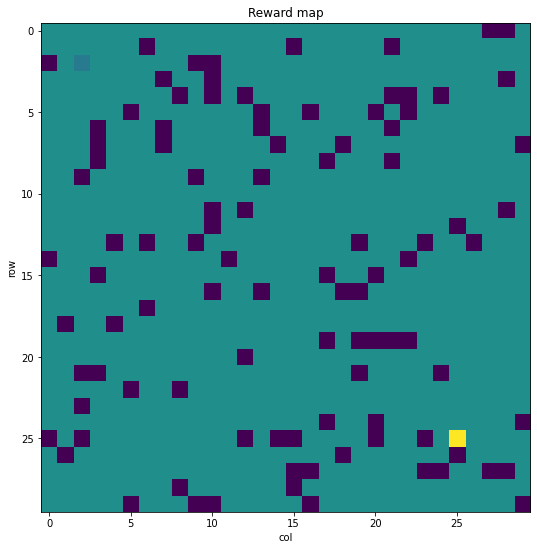

In [5]:
env.showmap()

In [6]:
# For stats
ep_rewards = []
aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': [], 'epsilon': []}

In [7]:
paths = []
goodpaths = []
for episode in range(EPISODES):
    episode_reward = 0 # Reset episode reward
    episode_steps = 0 # Reset episode steps
    state = env.reset(False)
    #if not episode %  STATS_EVERY: 
    #    print(f"Starting episode at: {state}")
    done = False

    if episode % SHOW_EVERY == 0:
        render = True
    else:
        render = False
    
    path = []
    while not done:
        action = env.get_next_action(env.x, env.y)

        new_state, reward, done, _, _ = env.step(action)
        #print(f"===> {state} - {new_state}")
        episode_steps += 1
        episode_reward += reward
        path.append(state)

        #if episode % SHOW_EVERY == 0:
        #    env.render()
        #new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)

        # If simulation did not end yet after last step - update Q table
        
        if not done:

            # Maximum possible Q value in next step (for new state)
            max_future_q = np.max(env.qtable[new_state[0],new_state[1]])

            # Current Q value (for current state and performed action):
            current_q = env.qtable[state[0],state[1],action]

            # And here's our equation for a new Q value for current state and action
            new_q = (1 - env.qsettings.learning_rate) * current_q + env.qsettings.learning_rate * (reward + env.qsettings.discount * max_future_q)
            #oldq = env.qtable[state[0], state[1], action]
            #temporaldiff = reward + (env.qsettings.discount * np.max(env.qtable[new_state[0], new_state[1]])) - oldq
            #new_q = oldq + (env.qsettings.learning_rate * temporaldiff)
            
            # Update Q table with new Q value
            env.qtable[state[0]][state[1]][action] = new_q


        # Simulation ended (for any reson) - if goal position is achived - update Q value with reward directly
        else:
            if (env.is_end(new_state[0], new_state[1])):
                env.qtable[state[0], state[1], action] = reward
                goodpaths.append(path)
            #print(f"EPISODE DONE ==>  reached food: {new_state == env.end_location}, reward: {episode_reward}, steps: {episode_steps}")
            #if (new_state & np.array(env.end_location)).all():
            #    env.qtable[state[0], state[1], action] = reward
            #    #env.qtable[state[0], state[1], action] = 0
            #    goodpaths.append(path)
        
        state = new_state

    # Decaying is being done every episode if episode number is within decaying range
    if env.qsettings.epsilon_end_decaying >= episode >= env.qsettings.epsilon_start_decaying:
        env.qsettings.epsilon -= env.qsettings.epsilon_decay_value
        
        
    ep_rewards.append(episode_reward)
    if not episode % STATS_EVERY:
        average_reward = sum(ep_rewards[-STATS_EVERY:])/STATS_EVERY
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(average_reward)
        aggr_ep_rewards['max'].append(max(ep_rewards[-STATS_EVERY:]))
        aggr_ep_rewards['min'].append(min(ep_rewards[-STATS_EVERY:]))
        print(f'Episode: {episode:>5d}, average reward: {average_reward:>4.1f}, current epsilon: {env.get_epsilon():>1.2f}')

env.close()

Episode:     0, average reward: -0.3, current epsilon: 1.00
Episode:  1000, average reward: -374.4, current epsilon: 0.99
Episode:  2000, average reward: -379.1, current epsilon: 0.98
Episode:  3000, average reward: -378.9, current epsilon: 0.97
Episode:  4000, average reward: -377.7, current epsilon: 0.96
Episode:  5000, average reward: -383.0, current epsilon: 0.95
Episode:  6000, average reward: -379.0, current epsilon: 0.94
Episode:  7000, average reward: -380.2, current epsilon: 0.93
Episode:  8000, average reward: -384.9, current epsilon: 0.92
Episode:  9000, average reward: -382.4, current epsilon: 0.91
Episode: 10000, average reward: -382.9, current epsilon: 0.90
Episode: 11000, average reward: -381.3, current epsilon: 0.89
Episode: 12000, average reward: -383.7, current epsilon: 0.88
Episode: 13000, average reward: -387.4, current epsilon: 0.87
Episode: 14000, average reward: -389.7, current epsilon: 0.86
Episode: 15000, average reward: -386.9, current epsilon: 0.85
Episode: 1

KeyboardInterrupt: 

In [ ]:
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="average rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min rewards")
plt.legend(loc=4)
plt.grid(True)
plt.show()

In [ ]:
print(len(goodpaths))

In [ ]:
print(env.qtable)